<h2>Time series forecasting on Criminal Acts using Pycaret</h2>

In [46]:
# Imports
from pycaret.time_series import setup, plot_model, compare_models, predict_model, create_model, tune_model, finalize_model
from pycaret.time_series import get_metrics, add_metric, remove_metric
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error 
import pandas as pd
import plotly.graph_objects as go

<h3>1. Problem Framing</h3>

Use the data provided by the SPVM (Service de police de la Ville de Montréal) to conduct a time series forecast on criminal activities in the city for the last 3 months of 2022.

<h3>2. Load and plot our preprocessed dataset</h3>

We cast the datatype of the column "Date" as Datetime and then we select this column as our index.

In [2]:
data = pd.read_csv("Data/ts_criminal_acts.csv", parse_dates=['Date'], index_col='Date')
data.shape

(2922, 1)

In [3]:
data.head(15)

,Total Crimes
Date,
2015-01-01,68
2015-01-02,80
2015-01-03,90
2015-01-04,51
2015-01-05,103
2015-01-06,85
2015-01-07,79
2015-01-08,98
2015-01-09,73


<Axes: xlabel='Date'>

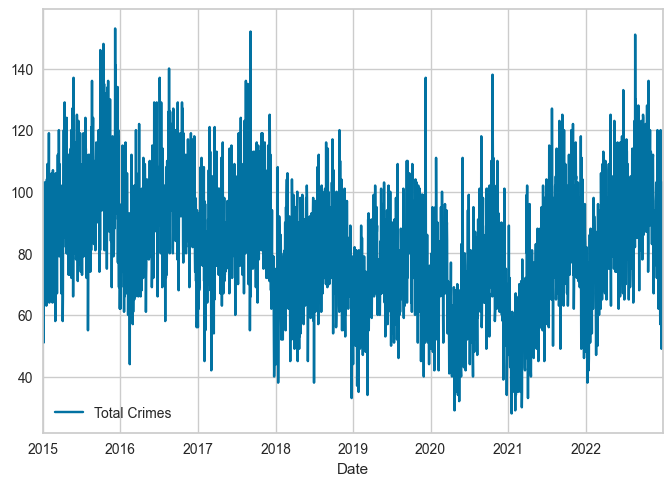

In [4]:
data.plot()

<h3>3. Creation of the validation and train_test sets.</h3>

Mark the last 3 months of 2022 as the validation set.

In [5]:
val_data = data.iloc[-90:]
train_test_data = data.drop(data.index[-90:])

print(train_test_data.shape)
print(val_data.shape)

(2832, 1)
(90, 1)


<h3>4. Setup of our experiment.</h3>

Here we defined our CV folds as 3 and the size of the test samples as 360 (aproximation of a year) and defined our evaluation metrics.

In [6]:
s = setup(train_test_data, fold=3, fh=360, session_id=42)

,Description,Value
0,session_id,42
1,Target,Total Crimes
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(2832, 1)"
5,Transformed data shape,"(2832, 1)"
6,Transformed train set shape,"(2472, 1)"
7,Transformed test set shape,"(360, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


This is the plot of the bigger CV sample. Remember that as we are dealing with organized data we cannot use the traditional method of CV, instead we have to use TimeSeriesSplit for our CV.

In [45]:
plot_model(plot='train_test_split')

These are the metrics used by default by Pycaret to evaluate our model. We are going to drop some of these and add others of our personal preference.

In [9]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Custom
ID,,,,,,,,
mase,MASE,MASE,<function mase at 0x000001BCE12D9360>,"make_scorer(mase, greater_is_better=False)",pred,{},False,False
rmsse,RMSSE,RMSSE,<function rmsse at 0x000001BCE12DA4D0>,"make_scorer(rmsse, greater_is_better=False)",pred,{},False,False
mae,MAE,MAE,<function mean_absolute_error at 0x000001BCDF1...,neg_mean_absolute_error,pred,{},False,False
rmse,RMSE,RMSE,<function mean_squared_error at 0x000001BCDF1F...,neg_root_mean_squared_error,pred,{'squared': False},False,False
mape,MAPE,MAPE,<function mape at 0x000001BCE12A6CB0>,"make_scorer(mape, greater_is_better=False)",pred,{},False,False
smape,SMAPE,SMAPE,<function _smape_loss at 0x000001BCE12A64D0>,"make_scorer(_smape_loss, greater_is_better=False)",pred,{},False,False
r2,R2,R2,<function r2_score at 0x000001BCDF1F6320>,r2,pred,{},True,False


In [10]:
# Dropping unwanted metrics.
unwanted_metrics = ['r2', 'smape', 'rmsse', 'mase', 'mae']
[remove_metric(metric) for metric in unwanted_metrics]
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Custom
ID,,,,,,,,
rmse,RMSE,RMSE,<function mean_squared_error at 0x000001BCDF1F...,neg_root_mean_squared_error,pred,{'squared': False},False,False
mape,MAPE,MAPE,<function mape at 0x000001BCE12A6CB0>,"make_scorer(mape, greater_is_better=False)",pred,{},False,False


In [11]:
# Adding a few metrics. 
add_metric('rmsle', 'RMSLE', mean_squared_log_error, squared=False, greater_is_better = False)
add_metric('mae', 'MAE', mean_absolute_error, greater_is_better = False)

get_metrics()


,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Custom
ID,,,,,,,,
rmse,RMSE,RMSE,<function mean_squared_error at 0x000001BCDF1F...,neg_root_mean_squared_error,pred,{'squared': False},False,False
mape,MAPE,MAPE,<function mape at 0x000001BCE12A6CB0>,"make_scorer(mape, greater_is_better=False)",pred,{},False,False
rmsle,RMSLE,RMSLE,<function mean_squared_log_error at 0x000001BC...,"make_scorer(mean_squared_log_error, greater_is...",pred,{'squared': False},False,True
mae,MAE,MAE,<function mean_absolute_error at 0x000001BCDF1...,"make_scorer(mean_absolute_error, greater_is_be...",pred,{},False,True


<h3>5. Model Training and Evaluating</h3>

Use Pycaret to automatically train and test more than 25 models. Then, select the best performing one for further experimentations.

In [12]:
best = compare_models(sort='MAPE')

,Model,RMSE,MAPE,RMSLE,MAE,TT (Sec)
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,16.7116,0.2052,0.2403,13.4409,3.9367
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,16.6336,0.2057,0.2404,13.3773,3.9100
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,16.6871,0.2092,0.2420,13.4479,3.9967
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,16.6871,0.2092,0.2420,13.4479,3.9500
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,16.6917,0.2094,0.2420,13.4539,3.8733
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,16.6956,0.2095,0.2421,13.4576,3.9433
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,16.7033,0.2097,0.2423,13.4660,4.3667
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,16.7033,0.2097,0.2423,13.4660,3.9167
polytrend,Polynomial Trend Forecaster,17.9954,0.2215,0.2590,14.4349,0.6533
theta,Theta Forecaster,17.9911,0.2459,0.2667,14.5515,0.6300


Current configuration of our best model.

In [13]:
print(best)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [35, 34,
                                                                        33, 32,
                                                                        31, 30,
                                                                        29, 28,
                                                                        27, 26,
                                                                        25, 24,
                                                                        23, 22,
                                                                        21, 20,
                                                                        19, 18,
                                                                        17, 16,
                                                                        15, 14,
                                                                        13, 12,
                                        

Here we are plotting a comparation between a forecast and the test data.

In [42]:
plot_model(best, plot='forecast', data_kwargs={'fh':360})

<h3>6. Hyperparameter Tuning</h3>

Automatically performed by Pycaret, we assigned our loss function to be the Mean Absolute Percentage Error (MAPE).

In [15]:
tuned_best = tune_model(best, optimize='MAPE')

,cutoff,RMSE,MAPE,RMSLE,MAE
0,2018-10-23,16.3301,0.1728,0.2256,12.6992
1,2019-10-18,16.0341,0.1949,0.2320,13.0145
2,2020-10-12,20.7223,0.2393,0.2908,16.6718
Mean,NaT,17.6955,0.2024,0.2494,14.1285
SD,NaT,2.1437,0.0277,0.0294,1.8030


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


In [43]:
plot_model(tuned_best, plot='forecast', data_kwargs={'fh':360})

<h3>7. Retrain the model using the test data and validate it using unseen data.</h3>

In an use case scenario we want to predict the actual future. To do this accurately we should retrain our model using the test data.

In this example we are going to predict only the last 3 months of 2022, for the model this is the actual future as he has not seen this data before.

In [18]:
final_model = finalize_model(tuned_best)

Final performance of the model.

In [41]:
val_pred = predict_model(final_model, fh=90)
final_mape = mean_absolute_percentage_error(y_true=val_data, y_pred=val_pred)
final_mae = mean_absolute_error(y_true=val_data, y_pred=val_pred)
final_rmsle = mean_squared_log_error(y_true=val_data, y_pred=val_pred, squared=False)

print(f"The MAPE on the validation set is: {final_mape}")
print(f"The MAE on the validation set is: {final_mae}")
print(f"The RMSLE on the validation set is: {final_rmsle}")

The MAPE on the validation set is: 0.16391567062684614
The MAE on the validation set is: 14.05517
The RMSLE on the validation set is: 0.18876101065301376


Plot of predictions vs actual values for our target.

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data["Total Crimes"],
                    mode='lines+markers',
                    name='lines+markers'))
fig.add_trace(go.Scatter(x=val_data.index, y=val_pred["y_pred"],
                    mode='lines+markers',
                    name='lines+markers'))
fig
fig.show()

In [48]:
plot_model(final_model, plot='forecast', data_kwargs={'fh':360})